In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

1. Загрузка датасета

In [2]:
df = pd.read_csv("CC GENERAL.csv")
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# 📘 Описание датасета CC GENERAL

Датасет содержит сведения о поведении клиентов кредитных карт: баланс, траты, платежи, кредитный лимит и активность использования карты.  
Используется для анализа клиентов и задач кластеризации.

## 🔑 Идентификатор
- **CUST_ID** — уникальный ID клиента (в моделях не используется).

## 💳 Баланс и его динамика
- **BALANCE** — средний баланс на кредитной карте.
- **BALANCE_FREQUENCY** — частота обновления баланса (0–1).

## 🛒 Покупки
- **PURCHASES** — общая сумма покупок.
- **ONEOFF_PURCHASES** — крупные единоразовые покупки.
- **INSTALLMENTS_PURCHASES** — покупки в рассрочку.
- **PURCHASES_FREQUENCY** — частота покупок (0–1).
- **ONEOFF_PURCHASES_FREQUENCY** — частота единоразовых покупок.
- **PURCHASES_INSTALLMENTS_FREQUENCY** — частота покупок в рассрочку.
- **PURCHASES_TRX** — количество покупок.

## 💵 Снятие наличных
- **CASH_ADVANCE** — сумма снятых наличных.
- **CASH_ADVANCE_FREQUENCY** — частота снятий наличных (0–1).
- **CASH_ADVANCE_TRX** — количество снятий.

## 🧾 Платежи
- **PAYMENTS** — сумма платежей по карте.
- **MINIMUM_PAYMENTS** — минимальный обязательный платеж.
- **PRC_FULL_PAYMENT** — доля месяцев с полной оплатой баланса (0–1).

## ⏳ Стаж клиента
- **TENURE** — количество месяцев обслуживания.

Датасет подходит для кластеризации и сегментации клиентов по уровню активности, типу трат, кредитной нагрузке и платёжной дисциплине.


2. Дескриптивный анализ: размерность, типы признаков, пропуски

In [3]:
print("Размерность датасета:", df.shape)

print("\nТипы признаков:")
print(df.dtypes)

print("\nКоличество пропусков в каждом столбце:")
print(df.isna().sum())


Размерность датасета: (8950, 18)

Типы признаков:
CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

Количество пропусков в каждом столбце:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY       

3. Обработка пропусков 

В этом датасете пропуски есть, например, в MINIMUM_PAYMENTS, CREDIT_LIMIT
.
Для старта можно сделать простую стратегию: заменить на медиану.

In [4]:
# Сохраним исходные названия колонок
cols = df.columns

# Удалим ID, если он есть
if 'CUST_ID' in df.columns:
    df = df.drop(columns=['CUST_ID'])

# Обработка пропусков: медиана по каждому числовому признаку
df = df.fillna(df.median(numeric_only=True))

df.isna().sum()



BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

В датасете присутствуют пропуски (NaN), которые не равны нулю и не означают фактическое значение признака. Замена пропусков на медиану является корректной стратегией, поскольку медиана минимально искажает распределение переменной и не создаёт искусственных выбросов. Такой подход позволяет сохранить структуру данных и обеспечивает корректную работу методов кластеризации.


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


4. Проверка распределения переменных (гистограммы + «похожесть» на нормальное)

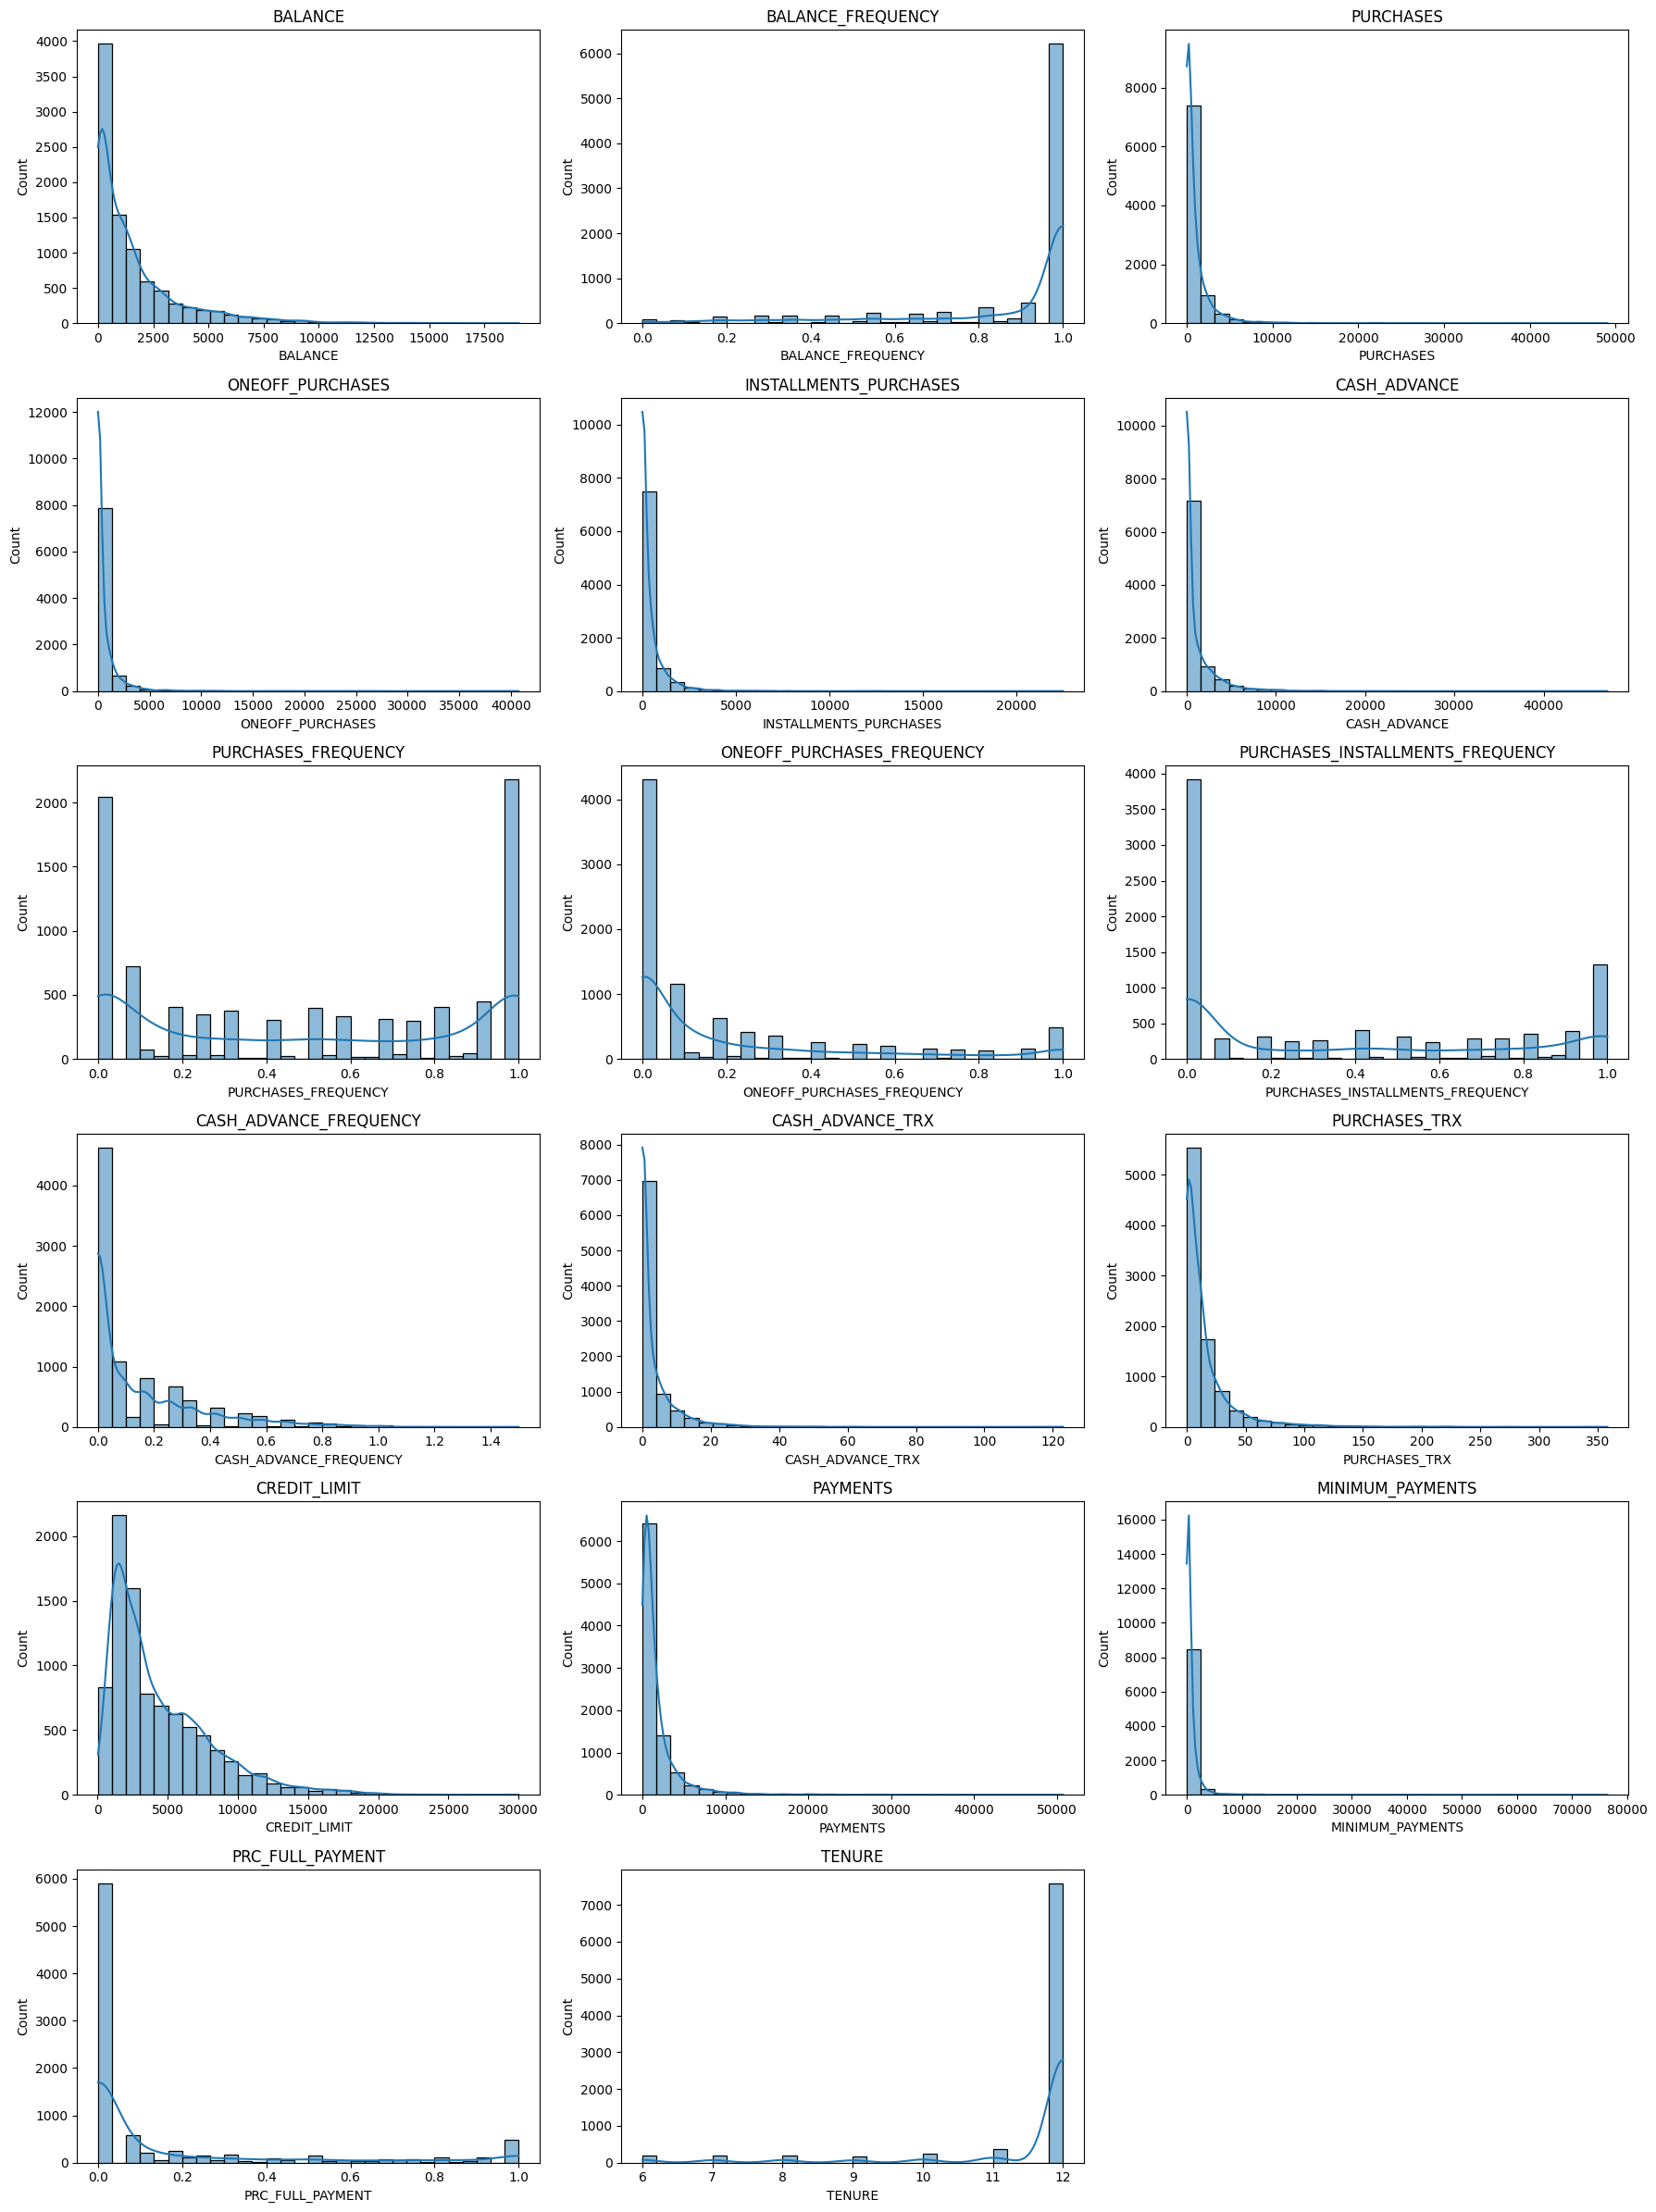

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Вычисляем количество признаков
num_cols = df.columns

# Размер сетки
n = len(num_cols)
rows = (n // 3) + 1  # 3 графика в строке

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()


Данные не являются нормальными, содержат выбросы и имеют разные масштабы. Это подтверждает необходимость масштабирования (StandardScaler) и использования методов кластеризации, устойчивых к таким данным (например, K-Means + GMM).

## Также мы удаляем признак TENURE из-за малой вариативности.

In [7]:
df = df.drop(columns=['TENURE'])

5. Информационная значимость / «полезность» признаков

Раз у нас нет классов, то формально посчитать классический feature importance нельзя.
Нам достаточно:

посмотреть дисперсии;

проверить признаки с почти нулевой вариацией (мало информативны);

посмотреть корреляции.

In [8]:
# Дисперсия признаков
variances = df.var()
print(variances.sort_values())


CASH_ADVANCE_FREQUENCY              4.004857e-02
BALANCE_FREQUENCY                   5.612351e-02
PRC_FULL_PAYMENT                    8.555578e-02
ONEOFF_PURCHASES_FREQUENCY          8.900441e-02
PURCHASES_INSTALLMENTS_FREQUENCY    1.579647e-01
PURCHASES_FREQUENCY                 1.610985e-01
CASH_ADVANCE_TRX                    4.657580e+01
PURCHASES_TRX                       6.179027e+02
INSTALLMENTS_PURCHASES              8.178274e+05
ONEOFF_PURCHASES                    2.755228e+06
BALANCE                             4.332775e+06
CASH_ADVANCE                        4.398096e+06
PURCHASES                           4.565208e+06
MINIMUM_PAYMENTS                    5.441920e+06
PAYMENTS                            8.381394e+06
CREDIT_LIMIT                        1.323975e+07
dtype: float64


Дисперсия признаков сильно различается из-за разной природы переменных: частотные признаки имеют диапазон 0–1 и, соответственно, малую дисперсию, в то время как денежные показатели варьируются на несколько порядков и обладают высокой дисперсией. Это подтверждает необходимость стандартизации данных перед кластеризацией, чтобы избежать доминирования признаков с большим масштабом.

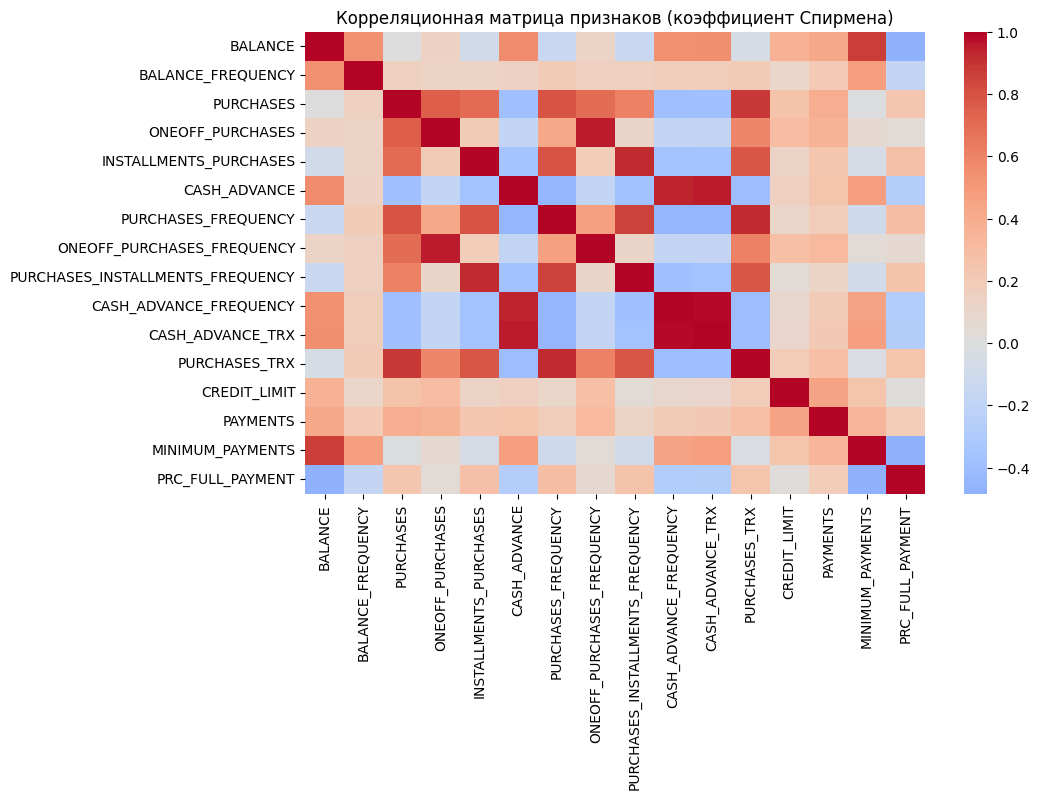

In [9]:

plt.figure(figsize=(10, 6))
sns.heatmap(
    df.corr(method='spearman'),
    cmap='coolwarm',
    center=0
)
plt.title("Корреляционная матрица признаков (коэффициент Спирмена)")
plt.show()


Корреляционная матрица Спирмена выявила группы признаков с высокой монотонной зависимостью, отражающие схожие аспекты финансового поведения клиентов, а также показала относительную независимость между различными типами операций. Это подтверждает целесообразность отбора и сокращения набора признаков перед применением методов кластеризации.

Признак PRC_FULL_PAYMENT практически не коррелирует с остальными переменными, поэтому он вносят независимую информацию о поведении клиентов. Это увеличивает разнообразие данных и позволяет алгоритмам кластеризации выделять дополнительные осмысленные группы.

6. Проверка условий для кластеризации 

Вопросы:

Отсутствие классов – да, в этом датасете нет метки класса → это чистая кластерация.

Осмысленность кластеризации – признаки описывают поведение клиентов по кредитке → логично искать группы (сегментация клиентов).

Отсутствие выбросов – проверим быстро: боксплоты по нескольким признакам.

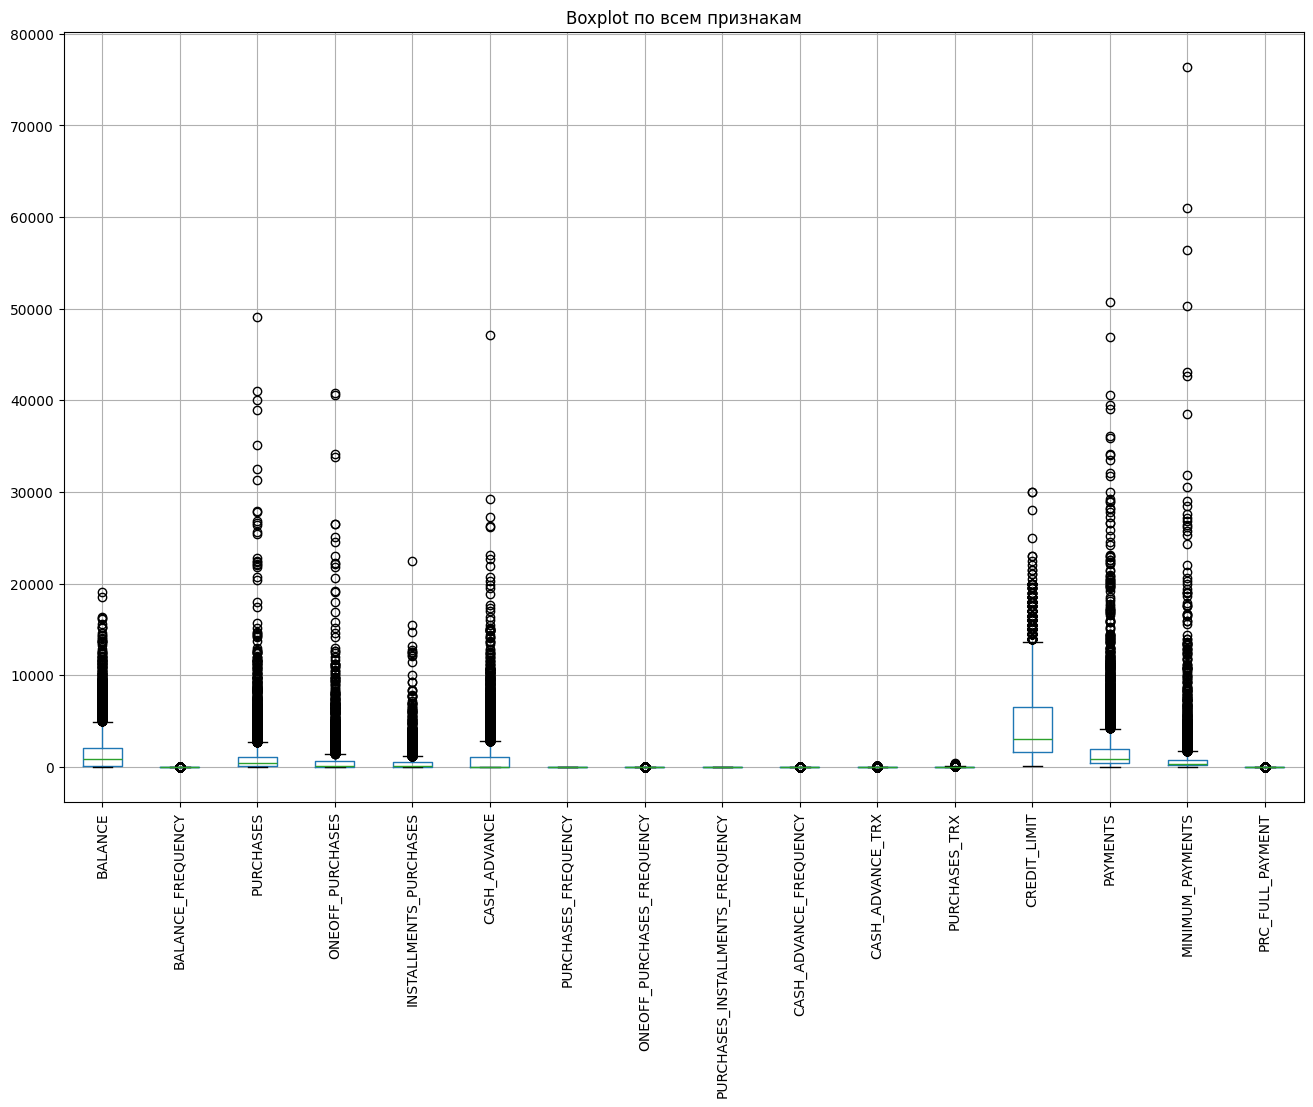

In [10]:
plt.figure(figsize=(16, 10))
df.boxplot(rot=90)
plt.title("Boxplot по всем признакам")
plt.show()

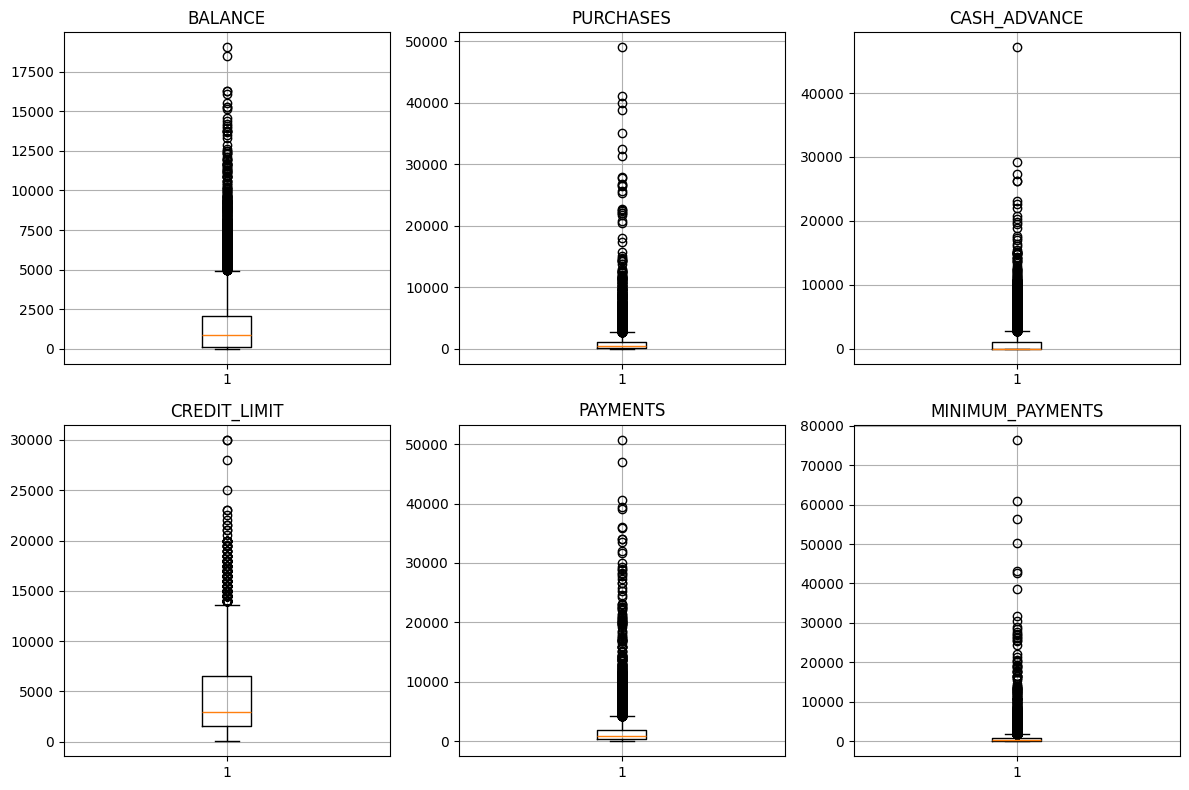

In [11]:
features = [
    'BALANCE',
    'PURCHASES',
    'CASH_ADVANCE',
    'CREDIT_LIMIT',
    'PAYMENTS',
    'MINIMUM_PAYMENTS'
]

plt.figure(figsize=(12, 8))

for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df[col].dropna())
    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.show()


В данных присутствуют выбросы, что типично для финансовых показателей.
Для кластеризации K-means это может быть проблемой, поэтому разумно дополнительно протестировать метод Gaussian Mixture / DBSCAN или, как минимум, провести стандартизацию.

## По проведенному анализу мы оставляем только значимые признаки:

    'PURCHASES',
    'CASH_ADVANCE',
    'BALANCE',
    'PAYMENTS',
    'CREDIT_LIMIT',
    'PRC_FULL_PAYMENT'

In [12]:
# Финальный набор информативных признаков
selected_features = [
    'PURCHASES',
    'CASH_ADVANCE',
    'BALANCE',
    'PAYMENTS',
    'CREDIT_LIMIT',
    'PRC_FULL_PAYMENT'
]

# Оставляем только выбранные признаки
df_selected = df[selected_features].copy()

# Проверка результата
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PURCHASES         8950 non-null   float64
 1   CASH_ADVANCE      8950 non-null   float64
 2   BALANCE           8950 non-null   float64
 3   PAYMENTS          8950 non-null   float64
 4   CREDIT_LIMIT      8950 non-null   float64
 5   PRC_FULL_PAYMENT  8950 non-null   float64
dtypes: float64(6)
memory usage: 419.7 KB


Для нашего датасета и выбранных признаков наиболее подходящим будет RobustScaler.
Почему именно RobustScaler:

Для набора признаков:

PURCHASES,
CASH_ADVANCE,
BALANCE,
PAYMENTS,
CREDIT_LIMIT,
PRC_FULL_PAYMENT.


характерно: сильная асимметрия распределений; наличие выбросов (что видно по boxplot и гистограммам); разные масштабы значений (от долей до десятков тысяч).

RobustScaler: масштабирует данные относительно медианы; использует межквартильный размах (IQR); устойчив к выбросам, в отличие от StandardScaler; сохраняет относительные различия между наблюдениями.

In [13]:
##from sklearn.preprocessing import StandardScaler

##scaler = StandardScaler()
##X_scaled = scaler.fit_transform(df_selected)

from sklearn.preprocessing import RobustScaler
import pandas as pd

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_selected)


data = pd.DataFrame(
    X_scaled,
    columns=df_selected.columns,
    index=df_selected.index
)
data


,PURCHASES,CASH_ADVANCE,BALANCE,PAYMENTS,CREDIT_LIMIT,PRC_FULL_PAYMENT
0,-0.248371,0.000000,-0.432267,-0.431595,-0.408163,0.000000
1,-0.337489,5.784542,1.209374,2.138626,0.816327,1.555556
2,0.384766,0.000000,0.842099,-0.154715,0.918367,0.000000
3,1.062798,0.184759,0.411913,-0.564547,0.918367,0.000000
4,-0.322542,0.000000,-0.028907,-0.117644,-0.367347,0.000000
...,...,...,...,...,...,...
8945,-0.065540,0.000000,-0.438709,-0.350037,-0.408163,3.500004
8946,-0.057245,0.000000,-0.443544,-0.382803,-0.408163,0.000000
8947,-0.202598,0.000000,-0.441355,-0.511003,-0.408163,1.750002
8948,-0.337489,0.032823,-0.446517,-0.529925,-0.510204,1.750002


8. Матрица диаграмм рассеяния (pairplot) для оценки структуры данных

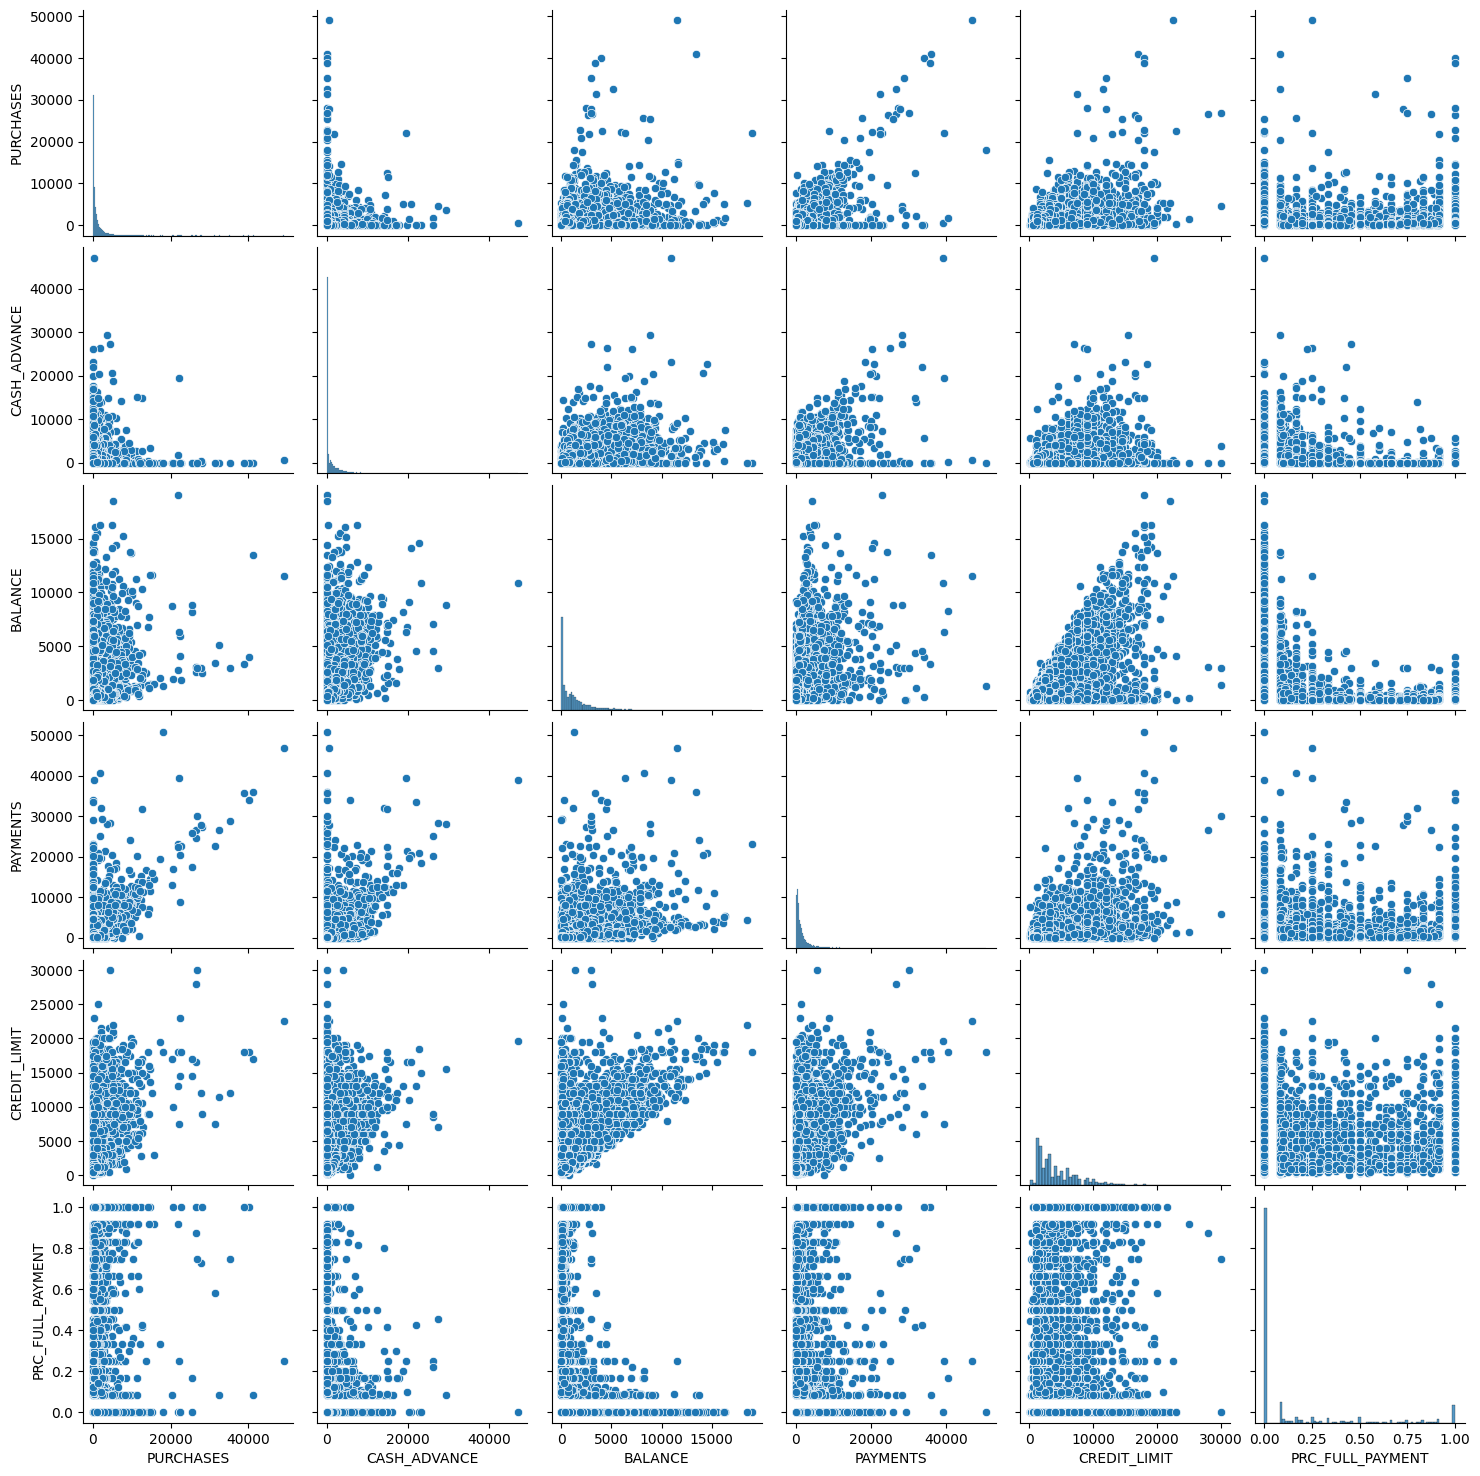

In [14]:
subset_cols = ['PURCHASES',
    'CASH_ADVANCE',
    'BALANCE',
    'PAYMENTS',
    'CREDIT_LIMIT',
    'PRC_FULL_PAYMENT']
sns.pairplot(df[subset_cols])
plt.show()

## Анализ диаграмм рассеяния и первичная оценка кластерной структуры

Для предварительного исследования структуры данных были построены диаграммы рассеяния (scatter matrix) по отобранным информативным признакам. Данный вид визуализации позволяет оценить характер распределения наблюдений в пространстве признаков, выявить плотные области концентрации точек и сформировать гипотезу о наличии кластерной структуры без применения формальных алгоритмов кластеризации.

В результате визуального анализа установлено, что данные не образуют чётко разделённых компактных групп, однако демонстрируют выраженную сегментацию по уровню и типу финансовой активности клиентов. На большинстве проекций наблюдается плотная концентрация точек в области малых значений показателей, что указывает на наличие крупного кластера клиентов с низкой или умеренной активностью использования кредитной карты. Данный кластер характеризуется небольшими объёмами покупок и наличных операций, а также умеренными значениями задолженности и платежей.

Помимо основного массива наблюдений, визуально выделяется группа клиентов с высокой покупательной активностью. На диаграммах, связывающих показатели `PURCHASES`, `PAYMENTS` и `CREDIT_LIMIT`, данная группа формирует отдельное вытянутое облако точек, отличающееся повышенными значениями объёма покупок и платежей. Это позволяет интерпретировать её как кластер активных пользователей карты.

Отдельно прослеживается группа клиентов, ориентированных на операции с наличными средствами. На проекциях с участием признака `CASH_ADVANCE` заметна область наблюдений с высокими значениями данного показателя при относительно умеренных покупках. Такая структура указывает на наличие специфического поведенческого сегмента, отличного от активных покупателей.

Признак платёжной дисциплины `PRC_FULL_PAYMENT` визуально не формирует самостоятельного компактного кластера, однако выступает фактором дополнительного расслоения внутри основных групп, разделяя клиентов по склонности к полному погашению задолженности.

Таким образом, на основе визуального анализа диаграмм рассеяния можно сделать вывод о наличии кластерной структуры, отражающей различные типы финансового поведения клиентов. Наиболее обоснованным является предположение о существовании трёх основных кластеров: клиентов с низкой или умеренной активностью, активных пользователей карты и клиентов, преимущественно использующих наличные операции. С учётом платёжной дисциплины возможно дополнительное уточнение структуры и расширение числа кластеров до четырёх.

Полученные визуальные наблюдения используются для формирования гипотезы о количестве кластеров и выборе методов дальнейшего анализа. Для подтверждения и уточнения структуры данных целесообразно применение иерархической кластеризации на этапе исследования и модели смесей гауссианов (GMM) на этапе финального разбиения, поскольку данные методы позволяют учитывать различную форму кластеров и их возможное перекрытие. Метод K-means может быть использован в качестве базового и сравнительного подхода.


# Шаг 1 — Подбор количества кластеров для K-means
1.1. Метод локтя (Elbow Method)

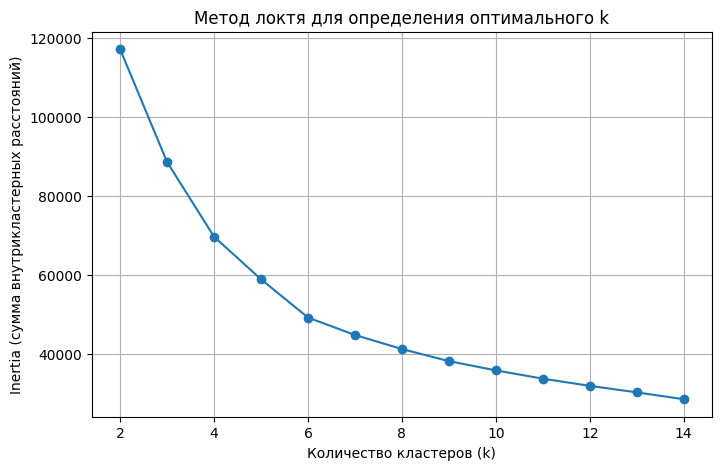

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title("Метод локтя для определения оптимального k")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Inertia (сумма внутрикластерных расстояний)")
plt.grid(True)
plt.show()


1.2. Метод силуэта (Silhouette Score)

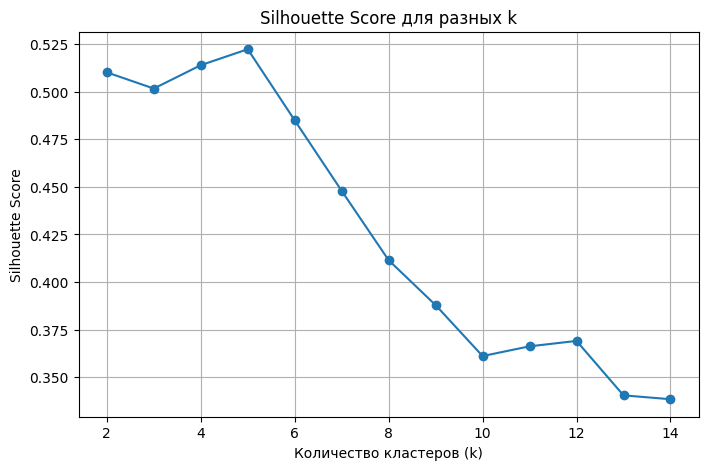

In [16]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score для разных k")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


По результатам метода силуэта максимальное качество кластеризации достигается при k = 5 но при k = 4 значение также высоко. Метод локтя показывает точку излома в диапазоне 3–4, в совокупности можно сделать выбор в сторону четырех кластеров как оптимального количества. Поэтому в дальнейших экспериментах используется значение k = 4.

## Шаг 2 — Кластеризация методом K-means с оптимальным k

По методу силуэта видно, что оптимальный k ≈ 4 .



In [17]:
optimal_k = 4  

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

df["kmeans_cluster"] = kmeans_labels

# добавляем метки в датафрейм
df["kmeans_cluster"] = kmeans_labels

# вывод размеров кластеров
cluster_counts_kmeans = (
    pd.Series(kmeans_labels)
    .value_counts()
    .sort_index()
)

print("Размеры кластеров (K-means):")
print(cluster_counts_kmeans)


Размеры кластеров (K-means):
0    6648
1    1340
2      92
3     870
Name: count, dtype: int64


## Кластеризация методом иерархической кластеризации

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import linkage, dendrogram

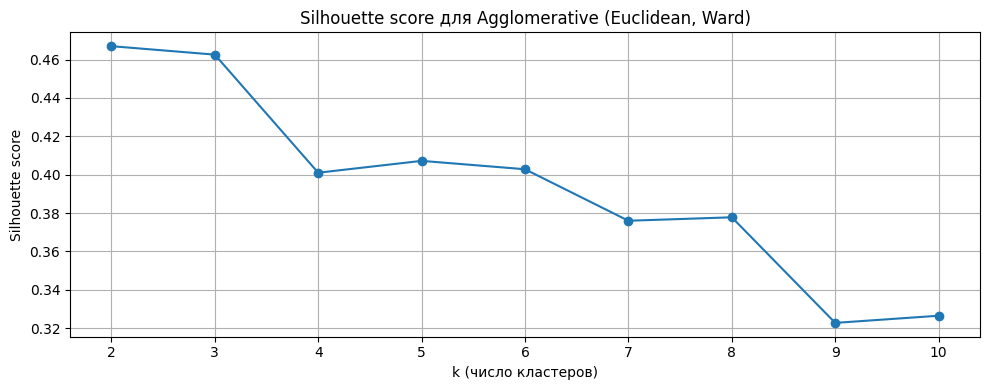

Лучшее k по silhouette (Agglomerative, Euclidean, Ward) в диапазоне 2–10: 2, silhouette=0.4670


In [19]:
# 2.2. Подбор количества кластеров по silhouette score
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k,linkage="ward")
    labels = model.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels, metric="euclidean"))

plt.figure(figsize=(10, 4))
plt.plot(list(k_range), sil_scores, marker="o")
plt.title("Silhouette score для Agglomerative (Euclidean, Ward)")
plt.xlabel("k (число кластеров)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()

best_k_hier = list(k_range)[int(np.argmax(sil_scores))]
print(f"Лучшее k по silhouette (Agglomerative, Euclidean, Ward) в диапазоне {k_range.start}–{k_range.stop-1}: "
      f"{best_k_hier}, silhouette={max(sil_scores):.4f}")

Анализ коэффициента силуэта показал максимальное значение при k = 2, что указывает на наиболее грубое разделение данных на две крупные группы. Однако такое разбиение не позволяет выявить различия в типах финансового поведения клиентов. При k = 3 значение silhouette остаётся высоким и при этом обеспечивает более детализированную и интерпретируемую кластерную структуру, соответствующую результатам визуального анализа. В связи с этим для дальнейшего анализа было выбрано k = 3.

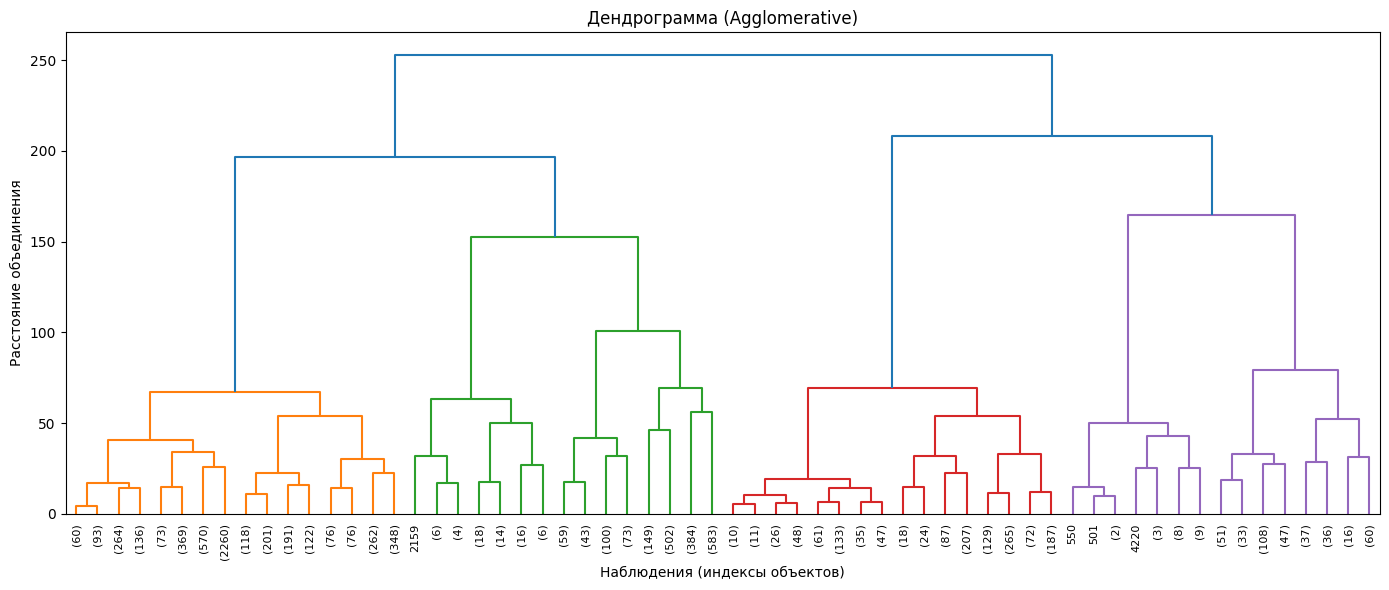

In [42]:
# 2.1. Дендрограмма (Manhattan distance + average linkage)
# Строим на подвыборке, т.к. полный набор (~8950 строк) визуализировать тяжело

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

np.random.seed(42)
sample_size = 8950  # можно 150–500 для наглядности
idx = np.random.choice(
    X_scaled.shape[0],
    size=min(sample_size, X_scaled.shape[0]),
    replace=False
)

X_sample = X_scaled[idx]

# Иерархическая кластеризация: Euclidean + Ward
Z = linkage(
    X_sample,
    method="ward" # Ward использует только Euclidean
)

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=idx,                 # подписи снизу (индексы объектов)
    leaf_rotation=90,           # поворот подписей
    leaf_font_size=8,           # размер шрифта
    truncate_mode="level",
    p=5
)

plt.title("Дендрограмма (Agglomerative)")
plt.xlabel("Наблюдения (индексы объектов)")
plt.ylabel("Расстояние объединения")
plt.tight_layout()
plt.show()


In [21]:
# 2.4. Финальная модель и распределение объектов по кластерам
hier_model = AgglomerativeClustering(n_clusters=3,linkage="ward")
hier_labels = hier_model.fit_predict(X_scaled)

# добавим метки кластеров в исходный df (как и для K-means)
df["hier_cluster"] = hier_labels

cluster_counts_hier = pd.Series(hier_labels).value_counts().sort_index()
print("Размеры кластеров (Agglomerative):")
print(cluster_counts_hier)


Размеры кластеров (Agglomerative):
0    7177
1     413
2    1360
Name: count, dtype: int64


In [22]:
print("Доля самого большого кластера:", cluster_counts_hier.max() / len(hier_labels))
print("Число кластеров:", len(np.unique(hier_labels)))

Доля самого большого кластера: 0.8018994413407822
Число кластеров: 3


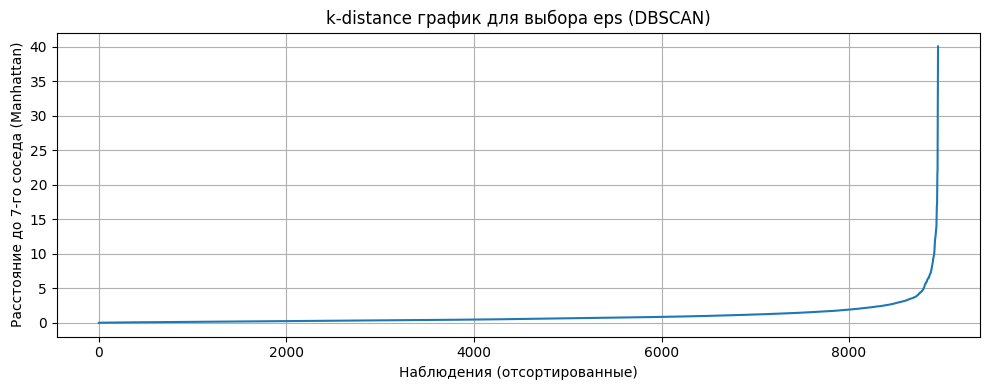

In [23]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# min_samples обычно берут = 2 * число признаков
min_samples = 7  # у тебя 6 признаков → логичный выбор 6+1

# модель ближайших соседей
neighbors = NearestNeighbors(
    n_neighbors=min_samples,
    metric="manhattan"
)

neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# берём расстояние до k-го соседа
k_distances = distances[:, -1]

# сортируем
k_distances_sorted = np.sort(k_distances)

# строим график
plt.figure(figsize=(10, 4))
plt.plot(k_distances_sorted)
plt.xlabel("Наблюдения (отсортированные)")
plt.ylabel(f"Расстояние до {min_samples}-го соседа (Manhattan)")
plt.title("k-distance график для выбора eps (DBSCAN)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

# параметры DBSCAN
eps = 3.5
min_samples = 6

dbscan = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    metric="manhattan"
)

dbscan_labels = dbscan.fit_predict(X_scaled)

# добавим метки в датафрейм
df["dbscan_cluster"] = dbscan_labels

In [25]:
# уникальные метки
unique_labels = np.unique(dbscan_labels)
print("Уникальные метки кластеров:", unique_labels)

# число кластеров (без шума, который обозначается -1)
n_clusters = len(unique_labels[unique_labels != -1])
print("Количество кластеров (без шума):", n_clusters)

# сколько объектов в каждом кластере
cluster_sizes = pd.Series(dbscan_labels).value_counts().sort_index()
print("\nРазмеры кластеров:")
print(cluster_sizes)

Уникальные метки кластеров: [-1  0]
Количество кластеров (без шума): 1

Размеры кластеров:
-1     175
 0    8775
Name: count, dtype: int64


## Метрики качества для двух методов

In [27]:
import numpy as np
import pandas as pd

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.metrics import pairwise_distances

def internal_metrics_table(X, labels_dict, metric_for_dist="euclidean"):
    """
    X: numpy array (например X_scaled)
    labels_dict: {"K-means": kmeans_labels, "Иерархическая кластеризация": hier_labels}
    metric_for_dist: метрика для меж/внутрикластерных расстояний и silhouette ("euclidean" или "manhattan")
    """

    def _one_method_metrics(X, labels, metric_for_dist):
        labels = np.asarray(labels)

        # если вдруг есть шум (-1), убираем его из расчётов
        mask = labels != -1
        X_use = X[mask]
        labels_use = labels[mask]

        uniq = np.unique(labels_use)
        if len(uniq) < 2:
            raise ValueError("Нужно минимум 2 кластера (без шума), чтобы посчитать метрики.")

        # --- центроиды кластеров
        centroids = np.vstack([X_use[labels_use == c].mean(axis=0) for c in uniq])

        # --- среднее межкластерное расстояние: средняя дистанция между центроидами
        Cdist = pairwise_distances(centroids, metric=metric_for_dist)
        iu = np.triu_indices_from(Cdist, k=1)
        inter_mean = float(Cdist[iu].mean())

        # --- среднее внутрикластерное расстояние: средняя дистанция точки до своего центроида
        intra_vals = []
        for i, c in enumerate(uniq):
            Xc = X_use[labels_use == c]
            if Xc.shape[0] == 0:
                continue
            d = pairwise_distances(Xc, centroids[i].reshape(1, -1), metric=metric_for_dist).ravel()
            intra_vals.append(d)
        intra_mean = float(np.concatenate(intra_vals).mean())

        # --- компактность (как на скрине): inter / intra
        compactness = float(inter_mean / intra_mean) if intra_mean > 0 else np.nan

        # --- silhouette: можно считать в выбранной метрике
        sil = float(silhouette_score(X_use, labels_use, metric=metric_for_dist))

        # --- Calinski–Harabasz и Davies–Bouldin (в sklearn по Euclidean на X_use)
        ch = float(calinski_harabasz_score(X_use, labels_use))
        db = float(davies_bouldin_score(X_use, labels_use))

        return {
            "Среднее межкластерное расстояние": inter_mean,
            "Средние внутрикластерные расстояния": intra_mean,
            "Компактность": compactness,
            "Силуэт": sil,
            "Calinski-Harabasz": ch,
            "Davies–Bouldin": db
        }

    # считаем метрики для каждого метода
    cols = {}
    for method_name, labels in labels_dict.items():
        cols[method_name] = _one_method_metrics(X, labels, metric_for_dist)

    # собираем в таблицу
    df_metrics = pd.DataFrame(cols)
    df_metrics.index.name = "Внутренние метрики"
    return df_metrics


# --- пример использования ---
# У тебя должны быть kmeans_labels и hier_labels (или df["kmeans_cluster"], df["hier_cluster"])
labels_dict = {
    "K-means": df["kmeans_cluster"].values,
    "Иерархическая кластеризация": df["hier_cluster"].values
}

# если хочешь как в Manhattan-логике:
metrics_df = internal_metrics_table(X_scaled, labels_dict, metric_for_dist="manhattan")

# или если хочешь полностью по Euclidean:
# metrics_df = internal_metrics_table(X_scaled, labels_dict, metric_for_dist="euclidean")

metrics_df



,K-means,Иерархическая кластеризация
Внутренние метрики,,
Среднее межкластерное расстояние,20.287455,12.830626
Средние внутрикластерные расстояния,4.034975,4.569667
Компактность,5.027901,2.807781
Силуэт,0.465670,0.411833
Calinski-Harabasz,3550.099030,2422.396053
Davies–Bouldin,0.937998,1.019711


## Оценка центров кластеров


In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances

# названия признаков, которые использовались при кластеризации
feature_names = [
    'PURCHASES',
    'CASH_ADVANCE',
    'BALANCE',
    'PAYMENTS',
    'CREDIT_LIMIT',
    'PRC_FULL_PAYMENT'
]

# ---------- K-means ----------
# центры берём напрямую из модели
kmeans_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=feature_names
)

print("Центры кластеров (K-means):")
display(kmeans_centers)


# ---------- Иерархическая кластеризация ----------
# считаем центроиды как средние значения признаков внутри кластеров
agg_centers = (
    pd.DataFrame(X_scaled, columns=feature_names)
    .assign(cluster=df["hier_cluster"].values)
    .groupby("cluster")[feature_names]
    .mean()
    .sort_index()
)

print("Центры кластеров (Иерархическая кластеризация):")
display(agg_centers)




Центры кластеров (K-means):


,PURCHASES,CASH_ADVANCE,BALANCE,PAYMENTS,CREDIT_LIMIT,PRC_FULL_PAYMENT
0,0.350705,0.492840,0.257377,0.164480,0.161231,0.260903
1,1.007493,0.082596,-0.376063,0.538377,0.366845,5.479324
2,13.613465,1.039074,1.721961,10.434294,1.894854,2.751510
3,0.497615,5.037869,2.122007,2.749296,1.139762,0.345193


Центры кластеров (Иерархическая кластеризация):


,PURCHASES,CASH_ADVANCE,BALANCE,PAYMENTS,CREDIT_LIMIT,PRC_FULL_PAYMENT
cluster,,,,,,
0,0.225047,1.056894,0.432355,0.420617,0.233421,0.254585
1,6.760441,0.421921,1.551862,4.028466,1.342813,1.568743
2,0.705638,0.077972,-0.391357,0.356038,0.367287,5.261168


## Ящик с усами для k-means

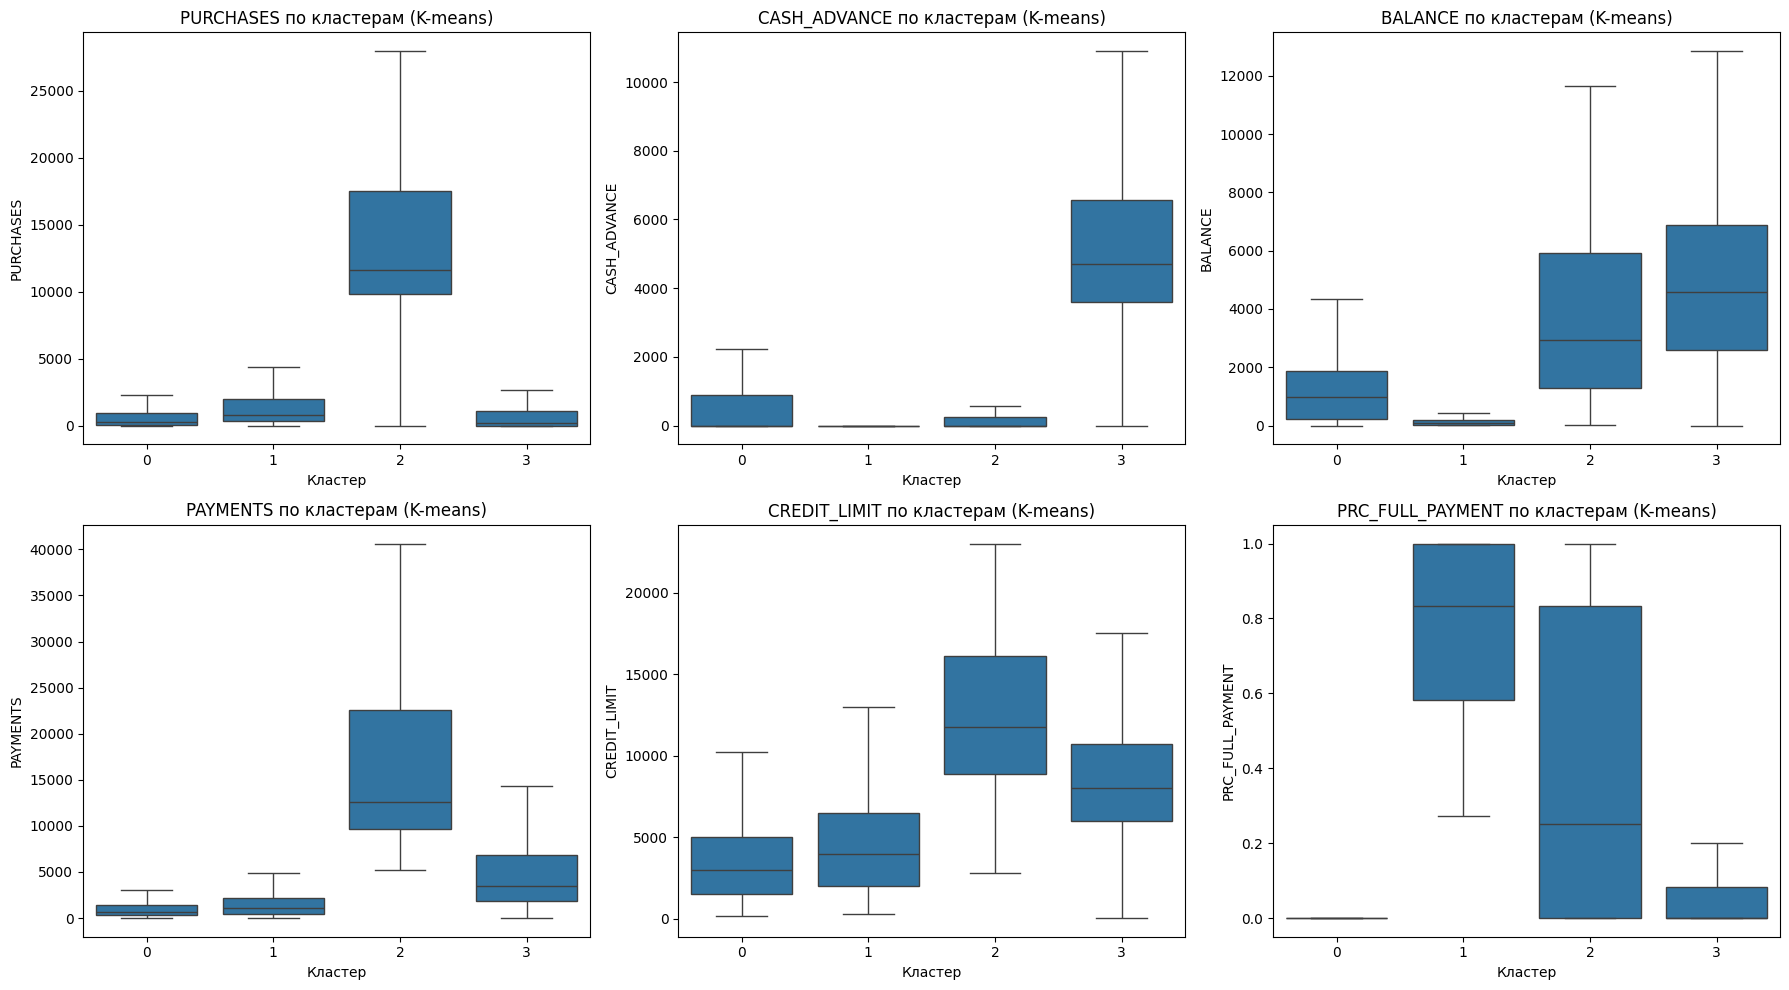

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "PURCHASES",
    "CASH_ADVANCE",
    "BALANCE",
    "PAYMENTS",
    "CREDIT_LIMIT",
    "PRC_FULL_PAYMENT"
]

plt.figure(figsize=(18, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        x="kmeans_cluster",
        y=feature,
        data=df,
        showfliers=False
    )
    plt.title(f"{feature} по кластерам (K-means)")
    plt.xlabel("Кластер")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


## Ящики с усами для иерархической кластеризации

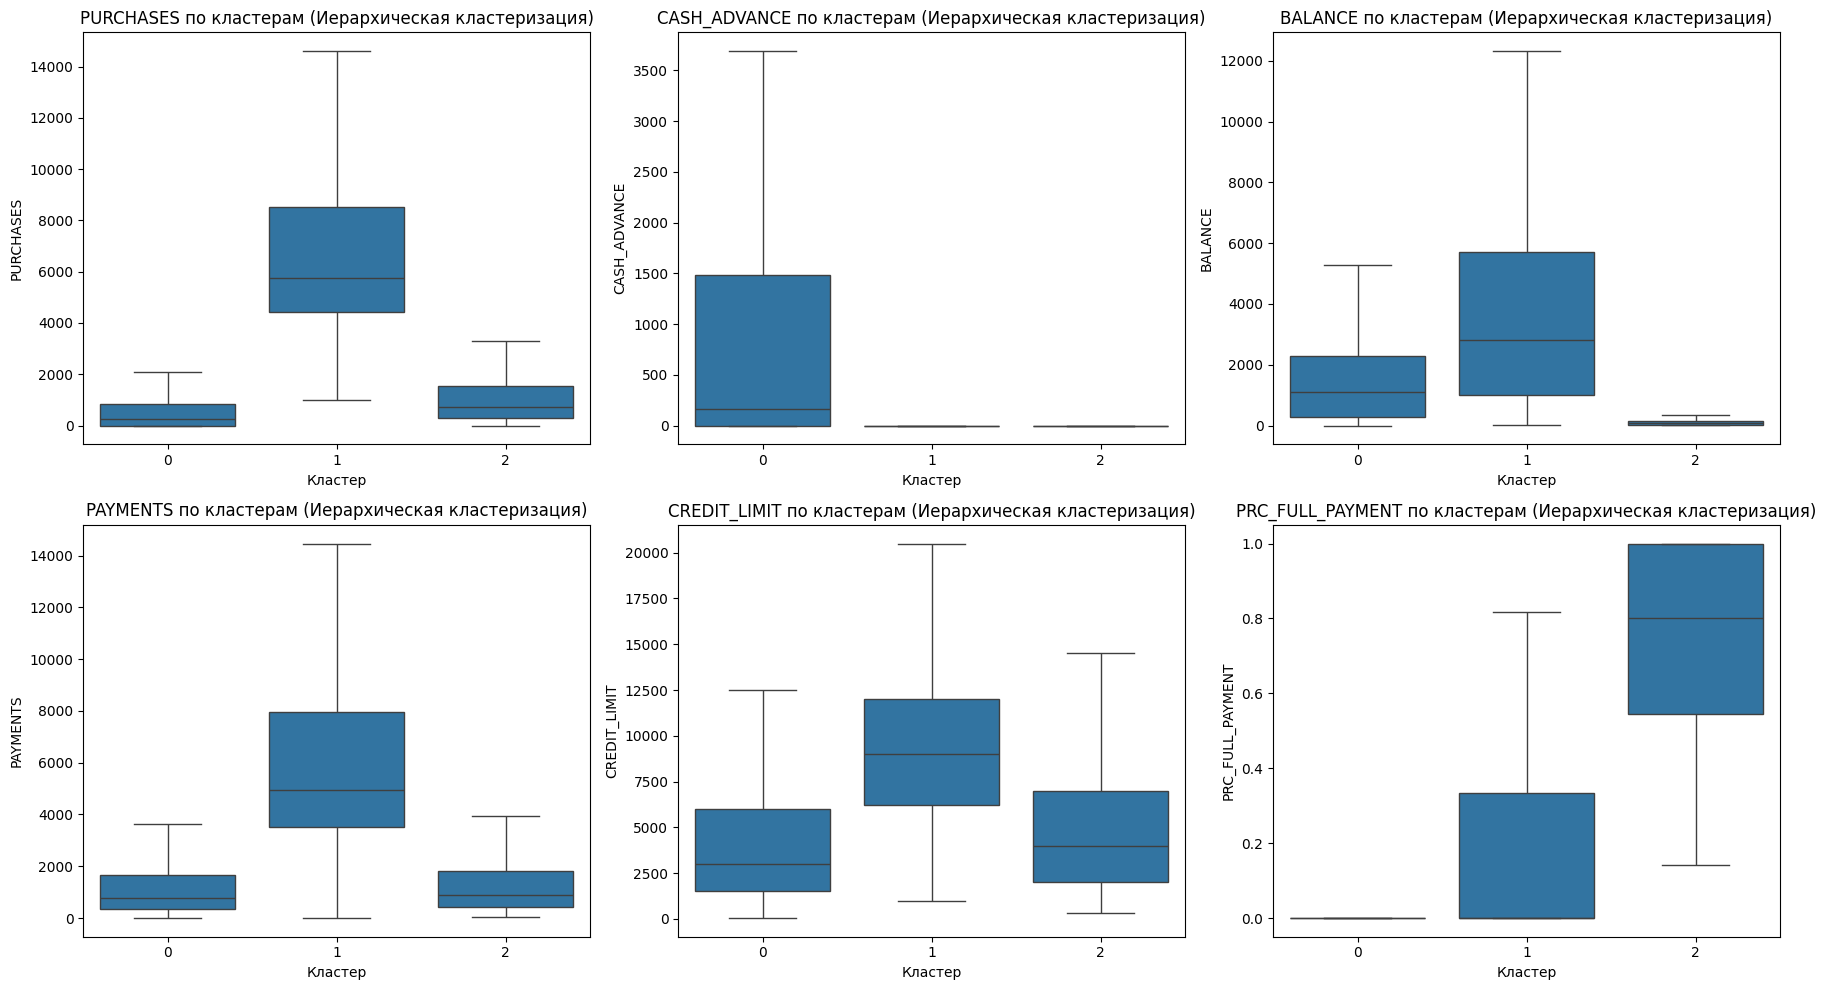

In [30]:
plt.figure(figsize=(18, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        x="hier_cluster",
        y=feature,
        data=df,
        showfliers=False
    )
    plt.title(f"{feature} по кластерам (Иерархическая кластеризация)")
    plt.xlabel("Кластер")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


In [31]:
import pandas as pd

# признаки, по которым считаем статистику
features = [
    "PURCHASES",
    "CASH_ADVANCE",
    "BALANCE",
    "PAYMENTS",
    "CREDIT_LIMIT",
    "PRC_FULL_PAYMENT"
]

def cluster_statistics(df, cluster_col, features):
    """
    Возвращает таблицу со статистиками mean / min / max по признакам для каждого кластера
    """
    stats = (
        df
        .groupby(cluster_col)[features]
        .agg(["mean", "min", "max"])
    )
    return stats


# ---------- K-means ----------
kmeans_stats = cluster_statistics(
    df,
    cluster_col="kmeans_cluster",
    features=features
)

print("Статистика признаков по кластерам (K-means):")
display(kmeans_stats)


# ---------- Иерархическая кластеризация ----------
hier_stats = cluster_statistics(
    df,
    cluster_col="hier_cluster",
    features=features
)

print("Статистика признаков по кластерам (Иерархическая кластеризация):")
display(hier_stats)


Статистика признаков по кластерам (K-means):


PURCHASES                CASH_ADVANCE                     \
                        mean  min       max         mean  min           max   
kmeans_cluster                                                                
0                 736.707432  0.0  11994.71   548.935887  0.0   4308.339621   
1                1439.796478  0.0   9113.78    91.997683  0.0   5632.549503   
2               14934.426087  0.0  49039.57  1157.342889  0.0  19513.474830   
3                 893.974448  0.0   9007.67  5611.285330  0.0  47137.211760   

                    BALANCE                             PAYMENTS               \
                       mean       min          max          mean          min   
kmeans_cluster                                                                  
0               1369.057416  0.000000  11416.64736   1106.559428     0.000000   
1                149.140542  0.074724   1565.98205   1674.081708    32.355459   
2               4189.637687  4.382924  19043.13856  16694.679583  5199.074518   
3               4960.070130  0.000000  18495.55855   5029.942975     0.000000   

                              CREDIT_LIMIT                  PRC_FULL_PAYMENT  \
                         max          mean     min      max             mean   
kmeans_cluster                                                                 
0                9821.138115   3790.030191   150.0  23000.0         0.037272   
1               12020.180090   4797.539462   300.0  25000.0         0.782760   
2               50721.483360  12284.782609  2800.0  30000.0         0.393072   
3               39048.597620   8584.832811    50.0  30000.0         0.049313   

                                    
                     min       max  
kmeans_cluster                      
0               0.000000  0.428571  
1               0.272727  1.000000  
2               0.000000  1.000000  
3               0.000000  1.000000

Статистика признаков по кластерам (Иерархическая кластеризация):


PURCHASES                   CASH_ADVANCE                     \
                     mean     min       max         mean  min           max   
hier_cluster                                                                  
0              602.191228    0.00   7194.53  1177.190761  0.0  47137.211760   
1             7598.298160  989.32  49039.57   469.944928  0.0  19513.474830   
2             1116.661529    0.00   5403.84    86.846405  0.0   5632.549503   

                  BALANCE                             PAYMENTS             \
                     mean        min          max         mean        min   
hier_cluster                                                                
0             1706.039730   0.000000  16304.88925  1495.337884   0.000000   
1             3862.051943  12.659909  19043.13856  6971.542053   0.000000   
2              119.687581   0.009684   1565.98205  1397.316630  32.355459   

                          CREDIT_LIMIT                  PRC_FULL_PAYMENT  \
                      max         mean     min      max             mean   
hier_cluster                                                               
0             40627.59524  4143.761356    50.0  30000.0         0.036369   
1             50721.48336  9579.782082  1000.0  30000.0         0.224106   
2             12902.18813  4799.707999   300.0  25000.0         0.751595   

                             
                   min  max  
hier_cluster                 
0             0.000000  1.0  
1             0.000000  1.0  
2             0.142857  1.0

## Оценка значимости с помощью дисперсионного анализа

In [32]:
from sklearn.feature_selection import f_classif
import pandas as pd
import numpy as np

# признаки, участвующие в кластеризации
features = [
    "PURCHASES",
    "CASH_ADVANCE",
    "BALANCE",
    "PAYMENTS",
    "CREDIT_LIMIT",
    "PRC_FULL_PAYMENT"
]

X = df[features]

# --- K-means ---
F_kmeans, p_kmeans = f_classif(X, df["kmeans_cluster"])

# --- Иерархическая кластеризация ---
F_hier, p_hier = f_classif(X, df["hier_cluster"])

# --- Сводная таблица ---
anova_table = pd.DataFrame({
    "Признак": features,
    "F-статистика K-means": F_kmeans,
    "p-value K-means": p_kmeans,
    "F-статистика Agglomerative": F_hier,
    "p-value Agglomerative": p_hier
})

# округлим для читаемости
anova_table = anova_table.round(4)

anova_table


,Признак,F-статистика K-means,p-value K-means,F-статистика Agglomerative,p-value Agglomerative
0,PURCHASES,2490.6944,0.0,3941.3356,0.0
1,CASH_ADVANCE,3395.5237,0.0,173.7356,0.0
2,BALANCE,1611.5970,0.0,687.1576,0.0
3,PAYMENTS,2300.5406,0.0,842.9392,0.0
4,CREDIT_LIMIT,740.1972,0.0,489.6807,0.0
5,PRC_FULL_PAYMENT,14511.8969,0.0,14701.8591,0.0


## Исследование влияние параметра k (количество кластеров) на качество кластеризации для K-means

In [39]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.metrics import pairwise_distances


results = []

k_values = [3, 4, 5, 6, 7]
n_init_values = [5, 10, 20]

for k in k_values:
    for n_init in n_init_values:
        kmeans = KMeans(
            n_clusters=k,
            random_state=42,
            n_init=n_init
        )
        labels = kmeans.fit_predict(X_scaled)

        # расстояния
        distances = pairwise_distances(X_scaled, metric="euclidean")

        intra_dists = []
        inter_dists = []

        for i in range(k):
            cluster_points = X_scaled[labels == i]

            # внутрикластерные расстояния
            if len(cluster_points) > 1:
                dists = pairwise_distances(cluster_points)
                intra_dists.append(dists.mean())

        for i in range(k):
            for j in range(i + 1, k):
                ci = X_scaled[labels == i]
                cj = X_scaled[labels == j]
                inter_dists.append(pairwise_distances(ci, cj).mean())

        mean_intra = np.mean(intra_dists)
        mean_inter = np.mean(inter_dists)
        compactness = mean_inter / mean_intra

        results.append({
            "n_clusters": k,
            "n_init": n_init,
            "Ср межкласт расстояние": mean_inter,
            "Ср внутрикласт расстояние": mean_intra,
            "Компактность": compactness,
            "Силуэт": silhouette_score(X_scaled, labels),
            "Calinski-Harabasz": calinski_harabasz_score(X_scaled, labels),
            "Davies-Bouldin": davies_bouldin_score(X_scaled, labels)
        })

kmeans_results_df = pd.DataFrame(results)
kmeans_results_df



,n_clusters,n_init,Ср межкласт расстояние,Ср внутрикласт расстояние,Компактность,Силуэт,Calinski-Harabasz,Davies-Bouldin
0,3,5,11.202059,6.333501,1.768699,0.501619,3235.938596,1.068754
1,3,10,11.202059,6.333501,1.768699,0.501619,3235.938596,1.068754
2,3,20,11.202059,6.333501,1.768699,0.501619,3235.938596,1.068754
3,4,5,12.801346,6.271734,2.041118,0.514044,3549.970727,0.933914
4,4,10,12.789361,6.269406,2.039964,0.513901,3550.099030,0.937998
5,4,20,12.789361,6.269406,2.039964,0.513901,3550.099030,0.937998
6,5,5,13.816515,6.442965,2.144434,0.472153,3448.367428,1.062230
7,5,10,16.609250,6.143301,2.703636,0.522281,3557.775292,0.939632
8,5,20,16.605952,6.140933,2.704141,0.522215,3557.788290,0.939637
9,6,5,16.597021,6.198317,2.677666,0.484917,3757.285036,0.907617


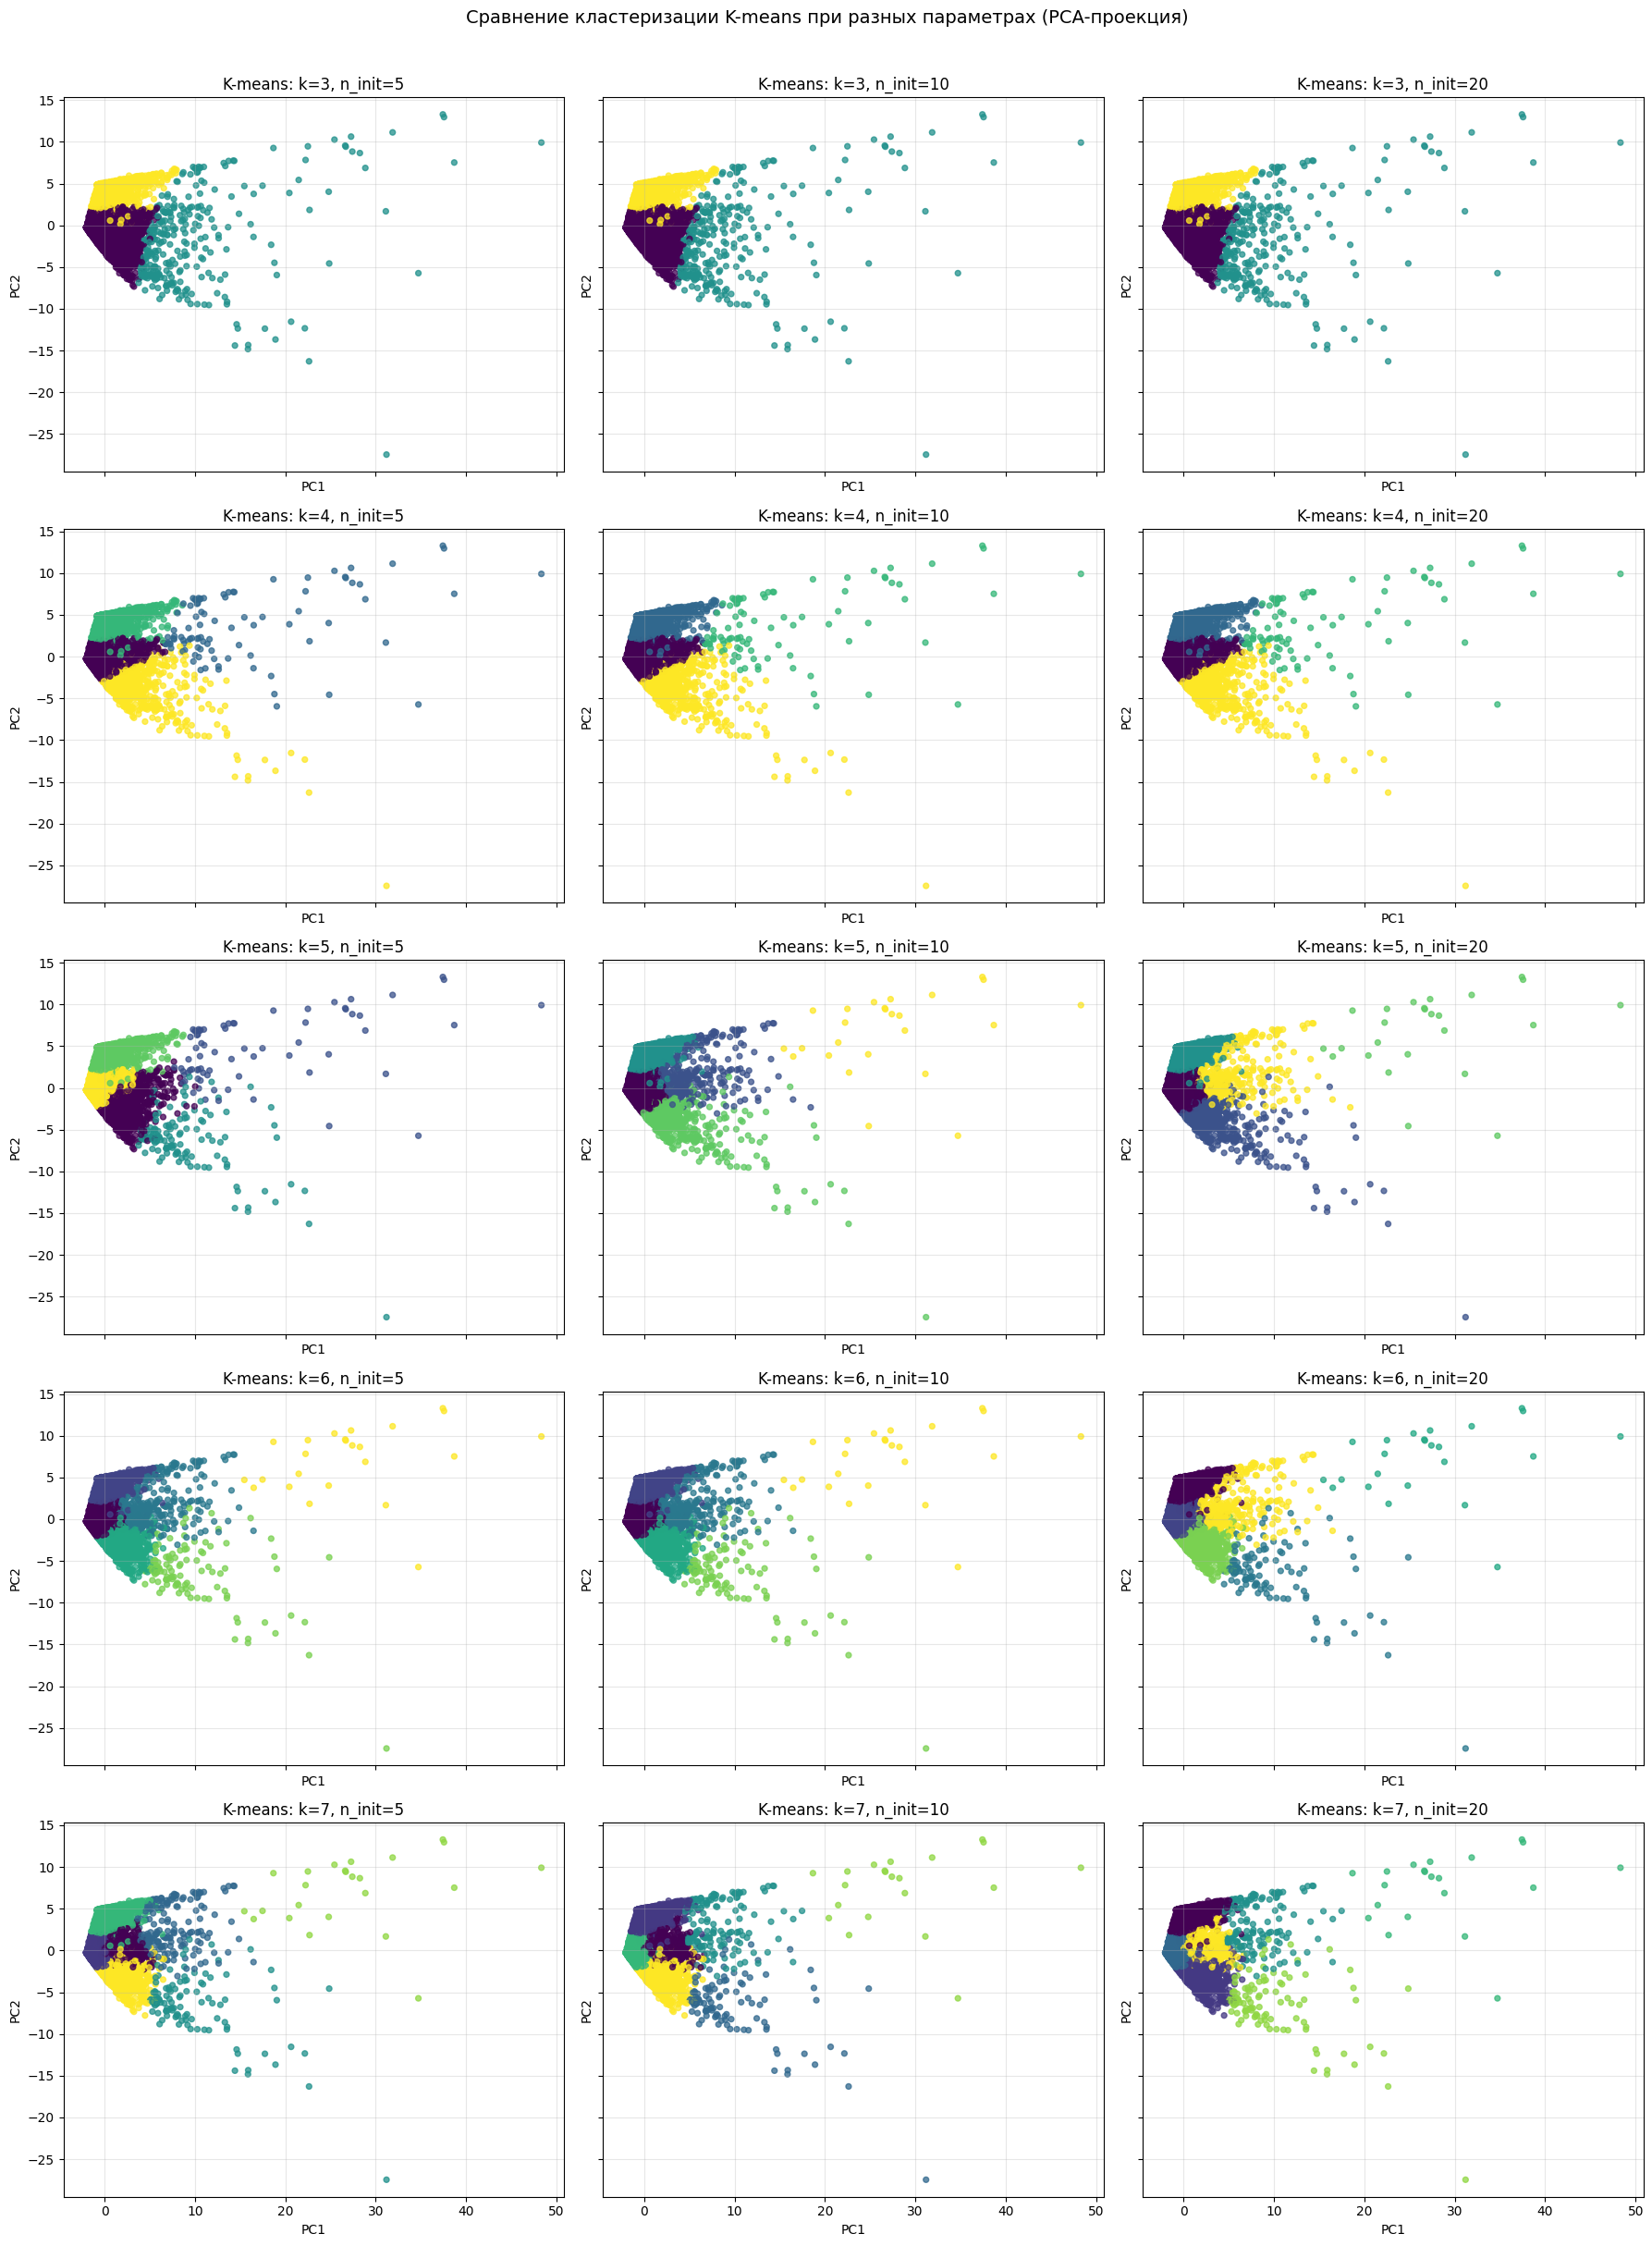

Explained variance ratio (PCA): [0.40372382 0.30112063] sum= 0.7048444535542684


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
# ---------------------------
# 1) Сетка подграфиков
# ---------------------------
combos = [(k, n_init) for k in k_values for n_init in n_init_values]
n_plots = len(combos)

ncols = 3  # можно 3 или 4
nrows = math.ceil(n_plots / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4.8*nrows), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)

# ---------------------------
# 2) Рисуем все комбинации
# ---------------------------
for ax, (k, n_init) in zip(axes, combos):
    km = KMeans(n_clusters=k, random_state=42, n_init=n_init)
    labels = km.fit_predict(X_scaled)

    sc = ax.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=labels,
        s=18,
        alpha=0.75
    )

    ax.set_title(f"K-means: k={k}, n_init={n_init}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.3)

# если подграфиков больше, чем комбинаций — скрываем лишние
for i in range(len(combos), len(axes)):
    axes[i].axis("off")

plt.suptitle("Сравнение кластеризации K-means при разных параметрах (PCA-проекция)", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

print("Explained variance ratio (PCA):", pca.explained_variance_ratio_, "sum=", pca.explained_variance_ratio_.sum())

На основе анализа Silhouette Score, Calinski–Harabasz и Davies–Bouldin можно заключить, что оптимальное число кластеров для метода K-means — k = 3.

Silhouette Score достигает максимума именно при k = 3, Calinski–Harabasz демонстрирует высокие значения в области k = 2–3, а Davies–Bouldin показывает характерный «локоть» в этой же зоне, после которого улучшение становится незначительным.

Таким образом, значение k = 3 обеспечивает наилучший баланс между компактностью кластеров и их разделимостью, не приводя к переусложнению модели.

## Визуализация кластеров

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

print("Доля объяснённой дисперсии:", pca.explained_variance_ratio_)
print("Суммарно:", pca.explained_variance_ratio_.sum())

Доля объяснённой дисперсии: [0.40372382 0.30112063]
Суммарно: 0.7048444535542684


## Метод K-means

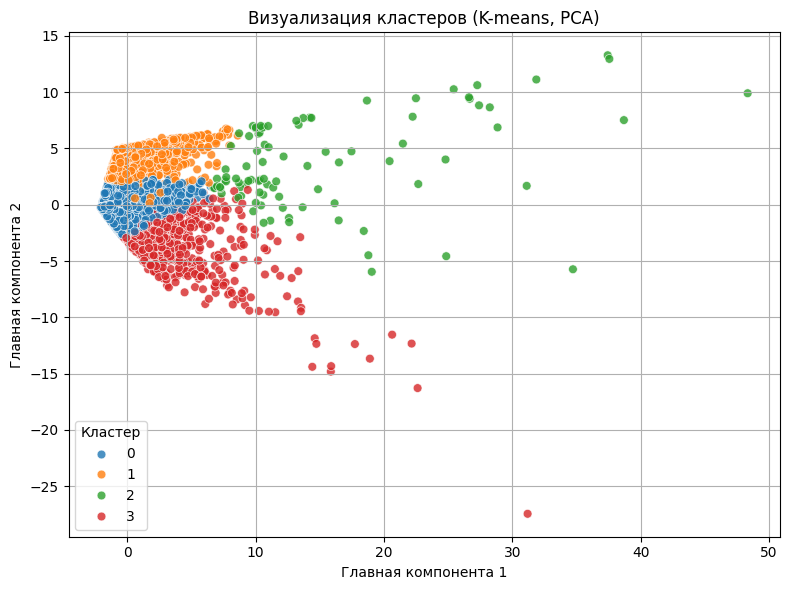

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="PC1",
    y="PC2",
    hue="kmeans_cluster",
    palette="tab10",
    s=40,
    alpha=0.8
)

plt.title("Визуализация кластеров (K-means, PCA)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


## Метод иерархической кластеризации

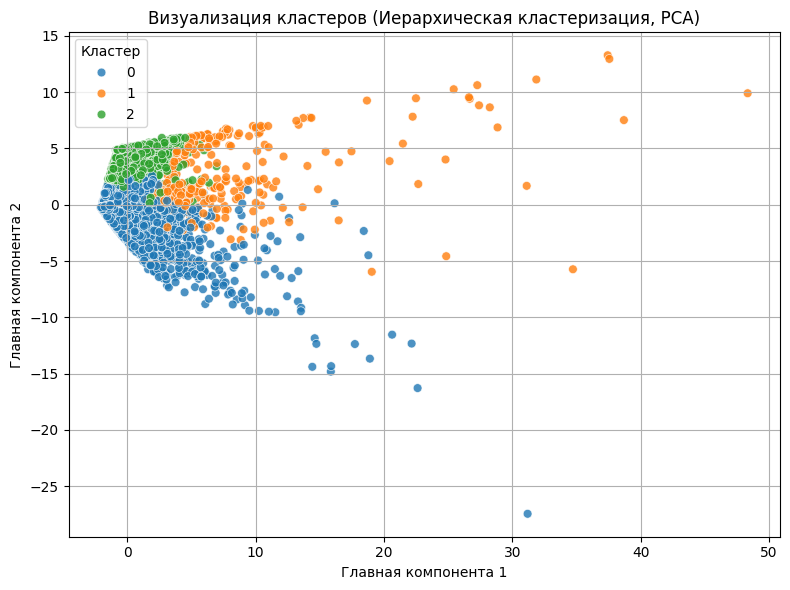

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="PC1",
    y="PC2",
    hue="hier_cluster",
    palette="tab10",
    s=40,
    alpha=0.8
)

plt.title("Визуализация кластеров (Иерархическая кластеризация, PCA)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


По результатам кластеризации методом K-means выделены три экономически интерпретируемые группы клиентов. Фиолетовый кластер отражает активных покупателей с высокими тратами и значительной кредитной нагрузкой(кластер 0). Бирюзовый кластер представляет низкоактивных пользователей с минимальными оборотами по карте(кластер 1). Жёлтый кластер объединяет клиентов, активно использующих карту для снятия наличных, что делает их более рискованными(кластер 2).

PCA-визуализация подтверждает хорошую разделимость кластеров K-means: группы имеют отчётливые границы и различную структуру расположения точек. В случае GMM наблюдается существенное перекрытие областей, что согласуется с низкими значениями внутренних метрик качества. Таким образом, метод K-means предоставляет более устойчивое и интерпретируемое разбиение выборки.